# Example for the Beijing Air Quality 2.5 Dataset

https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import dill

import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label='loss')
        plt.plot(self.x, self.val_losses, label='val_loss')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [5]:
dataset_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
df = pd.read_csv(dataset_link)

print(len(df), len(df.dropna()))

df_temp = df.copy()
df_temp = df_temp.dropna()
df_temp = df_temp.reset_index()


df_temp = df_temp.drop(['index', 'No', 'day', 'month', 'year', 'hour'], axis=1)
df_temp['cbwd'] = df_temp['cbwd'].astype('category').cat.codes

epochs = 150

normalize = True
standardize = False

min_max_dict = {}
std_mean_dict = {}

if normalize:

    for feature_name in df_temp.columns:
        max_value = df_temp[feature_name].max()
        min_value = df_temp[feature_name].min()

        df_temp[feature_name] = (df_temp[feature_name] - min_value) / (max_value - min_value)
        
        min_max_dict[feature_name] = {'max': max_value, 'min': min_value}
        
elif standardize:

    for feature_name in df_temp.columns:
        std_value = df_temp[feature_name].std()
        mean_value = df_temp[feature_name].mean()

        df_temp[feature_name] = (df_temp[feature_name] - mean_value) / std_value
        
        std_mean_dict[feature_name] = {'std': std_value, 'mean': mean_value}

43824 41757


In [6]:
df_temp.iloc[:10]

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,0.129779,0.352941,0.245902,0.527273,0.666667,0.002372,0.000000,0.0
1,0.148893,0.367647,0.245902,0.527273,0.666667,0.003947,0.000000,0.0
2,0.159960,0.426471,0.229508,0.545455,0.666667,0.005522,0.000000,0.0
3,0.182093,0.485294,0.229508,0.563636,0.666667,0.008690,0.037037,0.0
4,0.138833,0.485294,0.229508,0.563636,0.666667,0.010265,0.074074,0.0
5,0.109658,0.485294,0.213115,0.563636,0.666667,0.011840,0.111111,0.0
6,0.105634,0.485294,0.213115,0.581818,0.666667,0.015008,0.148148,0.0
7,0.124748,0.485294,0.229508,0.600000,0.666667,0.018176,0.000000,0.0
8,0.120724,0.470588,0.213115,0.600000,0.666667,0.021344,0.000000,0.0
9,0.132797,0.485294,0.229508,0.618182,0.666667,0.024512,0.000000,0.0


In [7]:
X_temp = df_temp.drop(['pm2.5'], axis=1)
y_temp = df_temp['pm2.5']

In [8]:
def create_sequences(X, y, n_steps=24):
    dataset_X = []
    dataset_y = []
    
    for i in range(len(X) - (n_steps + 2)):        
        dataset_X.append(X.iloc[i:i + n_steps].values)
        dataset_y.append(y.iloc[i + n_steps + 1])
        
    return np.asarray(dataset_X), np.asarray(dataset_y)

In [9]:
dataset_temp = create_sequences(X_temp, y_temp)

In [10]:
dataset_temp[0].shape

(41731, 24, 7)

In [11]:
dataset_temp[1].shape

(41731,)

In [12]:
X = dataset_temp[0]
y = dataset_temp[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [13]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(24, 7)))
cnn_model.add(layers.MaxPooling1D(2))
cnn_model.add(layers.Conv1D(64, 3, activation='relu'))
cnn_model.add(layers.MaxPooling1D(2))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(100, activation='relu'))
cnn_model.add(layers.Dropout(0.3))
cnn_model.add(layers.Dense(50, activation='relu'))
cnn_model.add(layers.Dropout(0.3))
cnn_model.add(layers.Dense(1))

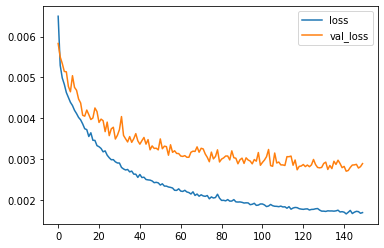

In [14]:
cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history = cnn_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=0, callbacks=[plot_losses])

In [15]:
dnn_model = models.Sequential()
dnn_model.add(layers.Flatten())
dnn_model.add(layers.Dense(500, activation='relu'))
dnn_model.add(layers.Dropout(0.3))
dnn_model.add(layers.Dense(250, activation='relu'))
dnn_model.add(layers.Dropout(0.3))
dnn_model.add(layers.Dense(100, activation='relu'))
dnn_model.add(layers.Dropout(0.3))
dnn_model.add(layers.Dense(1))

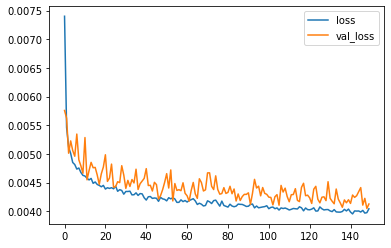

In [16]:
dnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history = dnn_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=0, callbacks=[plot_losses])

In [17]:
rnn_model = models.Sequential()
rnn_model.add(layers.LSTM(32, return_sequences=True))
rnn_model.add(layers.Flatten())
rnn_model.add(layers.Dense(100, activation='relu'))
rnn_model.add(layers.Dropout(0.3))
rnn_model.add(layers.Dense(1))

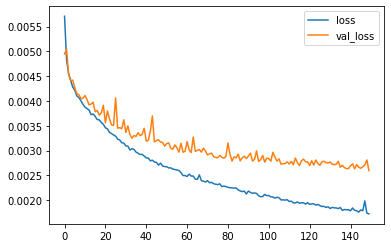

In [18]:
rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history = rnn_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=0, callbacks=[plot_losses])

In [19]:
dataset_test = [X_test, y_test]
dataset_test_reduced = [X_test[:10000], y_test[:10000]]

cnn_model.save('./beijing_air_2_5_cnn_model.h5')
dnn_model.save('./beijing_air_2_5_dnn_model.h5')
rnn_model.save('./beijing_air_2_5_rnn_model.h5')

with open('./beijing_air_2_5_test_data.dill', 'wb') as f:
    dill.dump(dataset_test, f)
    
with open('./beijing_air_2_5_test_data_reduced.dill', 'wb') as f:
    dill.dump(dataset_test_reduced, f)